## Import Relevant Packages

In [1]:
import torch
from torch import nn
from collections import OrderedDict
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch_model_manager import TorchModelManager
import copy

## I. Auto-Encoders with Default Loss Function

In [20]:
class Net(nn.Module):
    def __init__(self, input_dim, layers):
        super(Net, self).__init__()
        self.layers = self.create_layers(input_dim, layers)

    def create_layers(self, input_dim, layers):
        layer_list = []
        prev_dim = input_dim
        for idx, layer_dim in enumerate(layers):
            layer_list.append((f'fc{idx}', nn.Linear(prev_dim, layer_dim)))
            prev_dim = layer_dim

        return nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        layers = []
        for layer in self.layers:
            x = layer(x)
            layers.append(x)
        return x, layers
        

In [97]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, layers=[64, 32, 16]):
        super(AutoEncoder, self).__init__()
        assert all(x>=y for x, y in zip(layers, layers[1:])), "Layers must be sorted in decreasing order"

        self.encoder = Net(input_dim, layers)

        self.decoder = Net(layers[-1], layers[-2::-1]+[input_dim])

    def forward(self, x):
        x, enc_layers = self.encoder(x)
        x, dec_layers = self.decoder(x)
        return x, enc_layers, dec_layers

In [165]:
x = torch.linspace(0, 5, 128)
vector = torch.exp(x)

layers_dim = [64, 32, 16, 8]
input_dim = 128
model = AutoEncoder(input_dim, layers_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

epochs = 1000000
for i in range(epochs):
    optimizer.zero_grad()
    output, enc_layers, dec_layers = model(vector)

    loss = criterion(output, vector)
    loss.backward()
    optimizer.step()
    print(f'----------------------- Epoch {i}/{epochs} -----------------------')
    print(f'Loss: {loss.item()}')
    for idx in range(len(layers_dim)-1):

        print(f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')
    if loss < 1:
        break



----------------------- Epoch 0/1000000 -----------------------
Loss: 2276.02880859375
Loss 64: 816.54052734375
Loss 32: 295.48651123046875
Loss 16: 60.12925720214844
----------------------- Epoch 1/1000000 -----------------------
Loss: 2276.009033203125
Loss 64: 816.525146484375
Loss 32: 295.44439697265625
Loss 16: 60.10594177246094
----------------------- Epoch 2/1000000 -----------------------
Loss: 2275.9892578125
Loss 64: 816.509765625
Loss 32: 295.4025573730469
Loss 16: 60.08283233642578
----------------------- Epoch 3/1000000 -----------------------
Loss: 2275.969970703125
Loss 64: 816.4947509765625
Loss 32: 295.3609924316406
Loss 16: 60.059940338134766
----------------------- Epoch 4/1000000 -----------------------
Loss: 2275.9501953125
Loss 64: 816.479736328125
Loss 32: 295.3197021484375
Loss 16: 60.03725814819336
----------------------- Epoch 5/1000000 -----------------------
Loss: 2275.9306640625
Loss 64: 816.4649658203125
Loss 32: 295.2786560058594
Loss 16: 60.0147743225097

----------------------- Epoch 15/1000000 -----------------------
Loss: 2275.738037109375
Loss 64: 816.3276977539062
Loss 32: 294.8832702636719
Loss 16: 59.801361083984375
----------------------- Epoch 16/1000000 -----------------------
Loss: 2275.718994140625
Loss 64: 816.3151245117188
Loss 32: 294.84521484375
Loss 16: 59.78114318847656
----------------------- Epoch 17/1000000 -----------------------
Loss: 2275.7001953125
Loss 64: 816.302490234375
Loss 32: 294.80743408203125
Loss 16: 59.761146545410156
----------------------- Epoch 18/1000000 -----------------------
Loss: 2275.680908203125
Loss 64: 816.2902221679688
Loss 32: 294.7698669433594
Loss 16: 59.7413330078125
----------------------- Epoch 19/1000000 -----------------------
Loss: 2275.662109375
Loss 64: 816.2780151367188
Loss 32: 294.73260498046875
Loss 16: 59.72172546386719
----------------------- Epoch 20/1000000 -----------------------
Loss: 2275.642822265625
Loss 64: 816.2660522460938
Loss 32: 294.69561767578125
Loss 16: 59

In [5]:
def compare_input_output(input, output, title):
    # Create an array of indices
    indices = np.arange(len(output))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(indices, input, label='Input')
    plt.plot(indices, output, label='Output')
    plt.xlabel('Index')
    plt.ylabel('Output')
    plt.title(title)
    plt.legend()
    plt.show()

### Compare the Output of the Final Layer

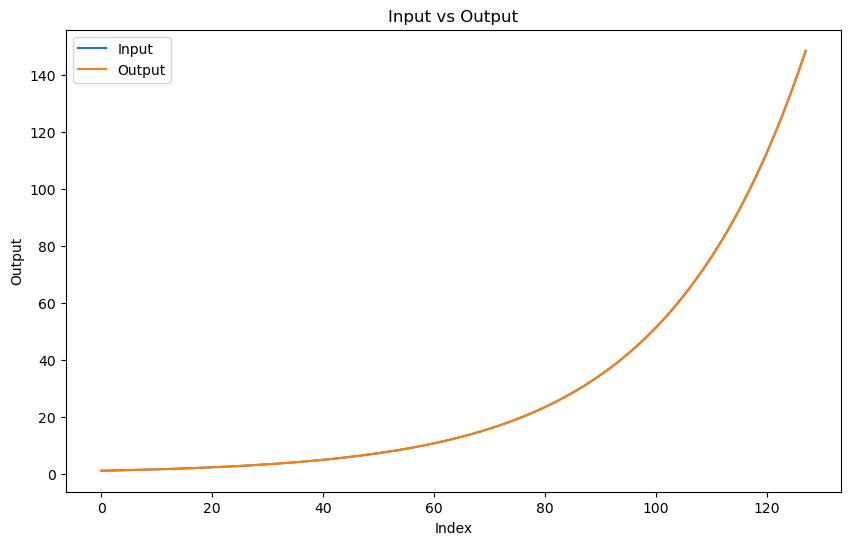

In [6]:
# compare_input_output(enc_layers[1].detach().numpy(), dec_layers[-3].detach().numpy())
compare_input_output(vector, model(vector)[0].detach(), title='Input vs Output')

### Compare the Outputs of Intermediate Layers

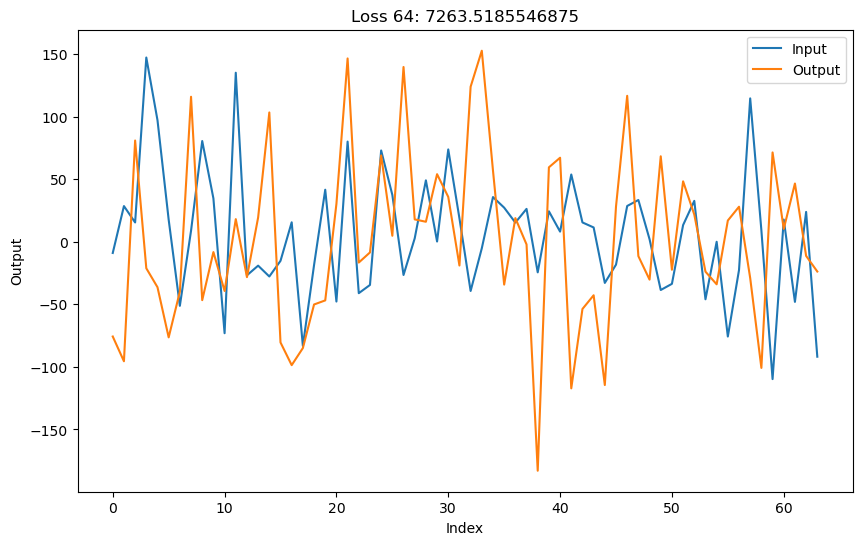

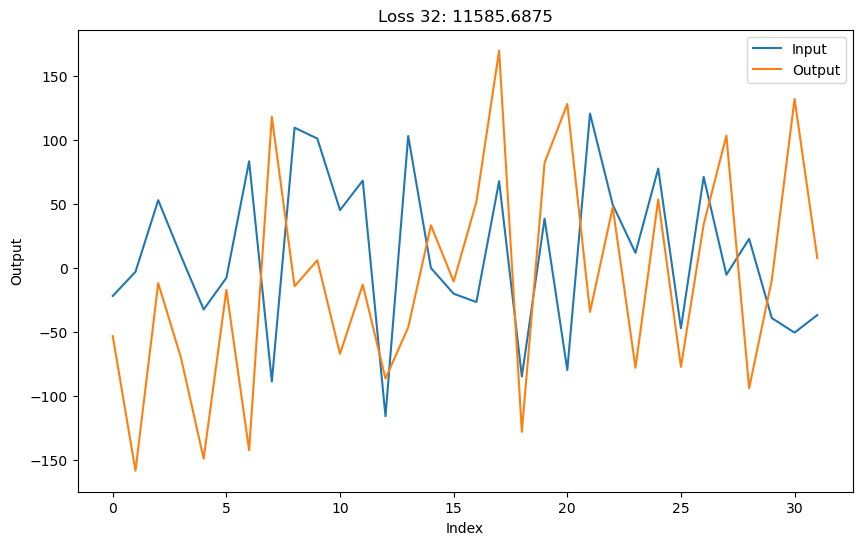

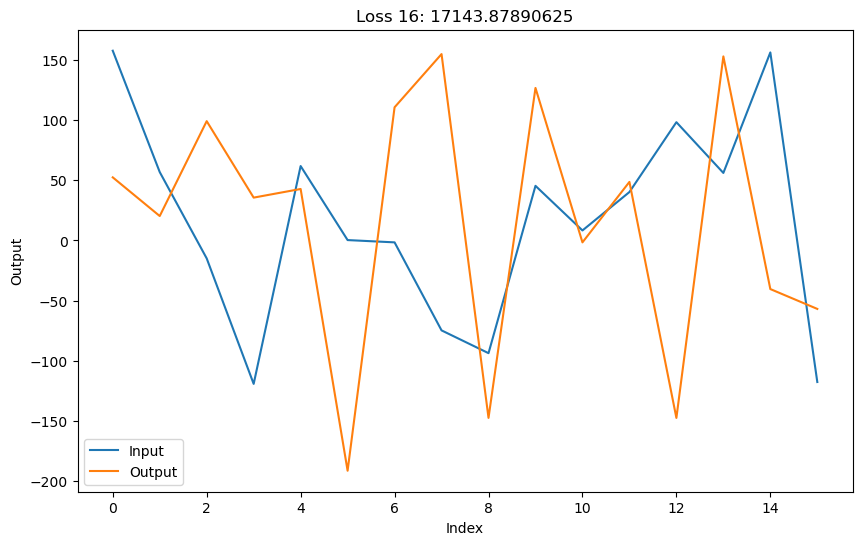

In [7]:
for idx in range(len(layers_dim)-1):
    compare_input_output(enc_layers[idx].detach().numpy(), dec_layers[-idx-2].detach().numpy(), title=f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')

## II. Auto-Encoders with Modified Loss Function

In [132]:
class AutoEncoderModified(nn.Module):
    def __init__(self, input_dim, layers=[64, 32, 16]):
        super(AutoEncoderModified, self).__init__()
        assert all(x>=y for x, y in zip(layers, layers[1:])), "Layers must be sorted in decreasing order"

        self.encoder = Net(input_dim, layers)
        self.decoder = Net(layers[-1], layers[-2::-1]+[input_dim])

    def forward(self, x):
        x, enc_layers = self.encoder(x)
        x, dec_layers = self.decoder(x)
        loss = criterion(x, vector)
        for idx in range(len(layers_dim)-1):
            loss += criterion(enc_layers[idx], dec_layers[-idx-2])
        
        return x, enc_layers, dec_layers, loss

In [143]:
aem = AutoEncoderModified(input_dim, layers_dim)
optimizer = torch.optim.Adam(aem.parameters(), lr=0.000001)
epochs = 100000000
for epoch in range(epochs):
    optimizer.zero_grad()
    output, enc_layers, dec_layers, loss = aem(vector)

    loss.backward()
    optimizer.step()

    print(f'----------------------- Epoch {epoch}/{epochs} -----------------------')
    print(f'Loss: {loss.item()}')

    if loss < 1:
        break



----------------------- Epoch 0/100000000 -----------------------
Loss: 3572.4306640625
----------------------- Epoch 1/100000000 -----------------------
Loss: 3572.06884765625
----------------------- Epoch 2/100000000 -----------------------
Loss: 3571.707763671875
----------------------- Epoch 3/100000000 -----------------------
Loss: 3571.346435546875
----------------------- Epoch 4/100000000 -----------------------
Loss: 3570.985595703125
----------------------- Epoch 5/100000000 -----------------------
Loss: 3570.624755859375
----------------------- Epoch 6/100000000 -----------------------
Loss: 3570.26416015625
----------------------- Epoch 7/100000000 -----------------------
Loss: 3569.903076171875
----------------------- Epoch 8/100000000 -----------------------
Loss: 3569.542724609375
----------------------- Epoch 9/100000000 -----------------------
Loss: 3569.18212890625
----------------------- Epoch 10/100000000 -----------------------
Loss: 3568.822021484375
--------------

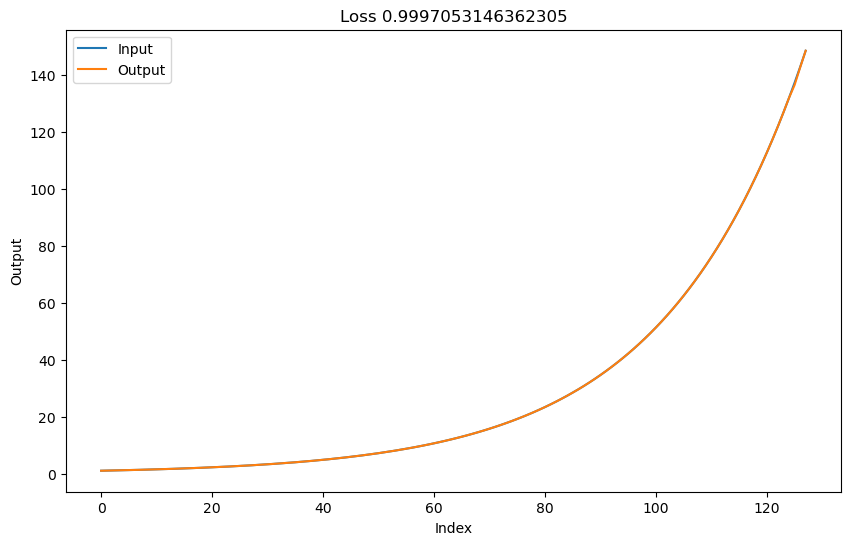

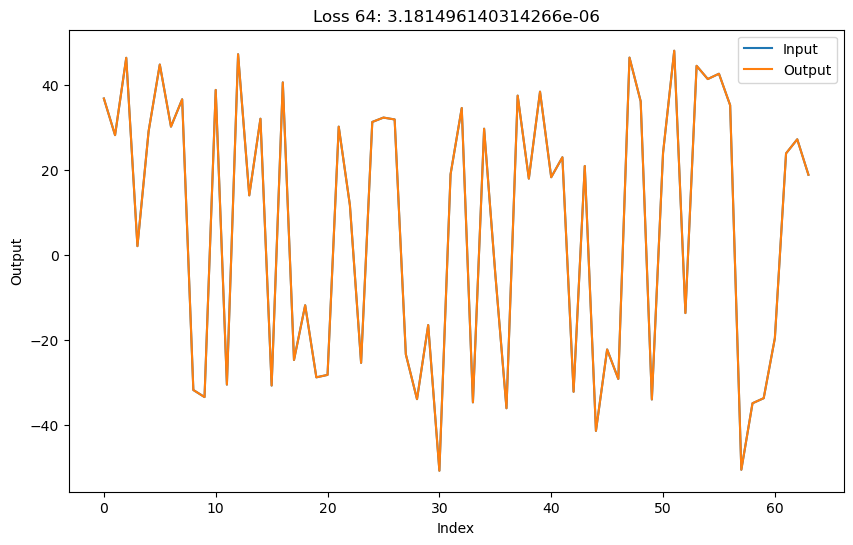

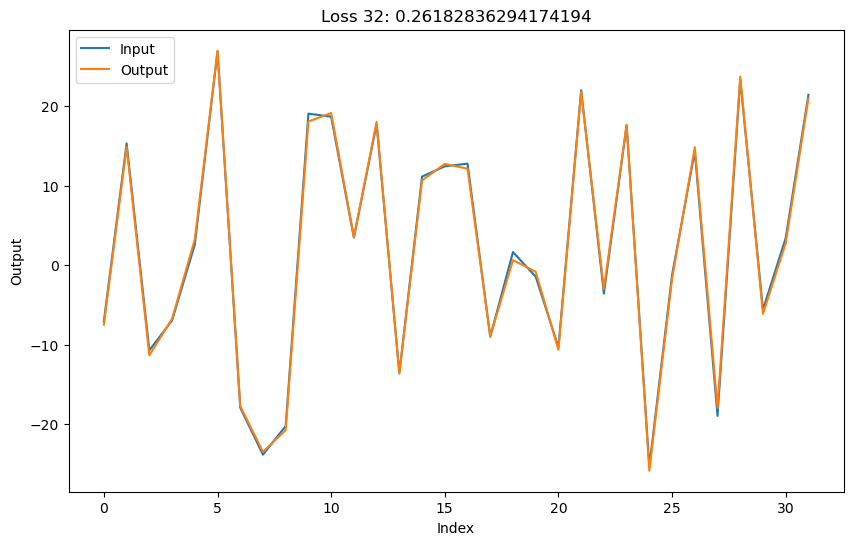

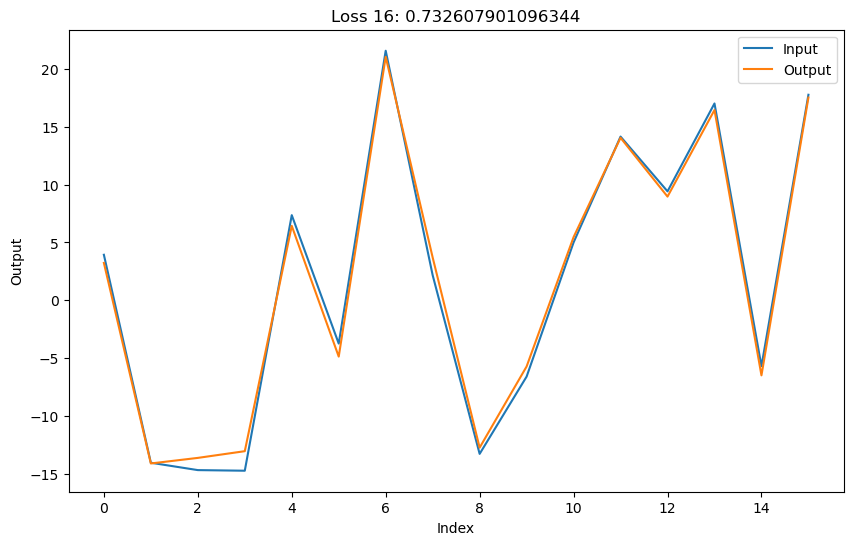

In [144]:
compare_input_output(vector, output.detach().numpy(), title=f'Loss {loss.item()}')
for idx in range(len(layers_dim)-1):
    compare_input_output(enc_layers[idx].detach().numpy(), dec_layers[-idx-2].detach().numpy(), title=f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')

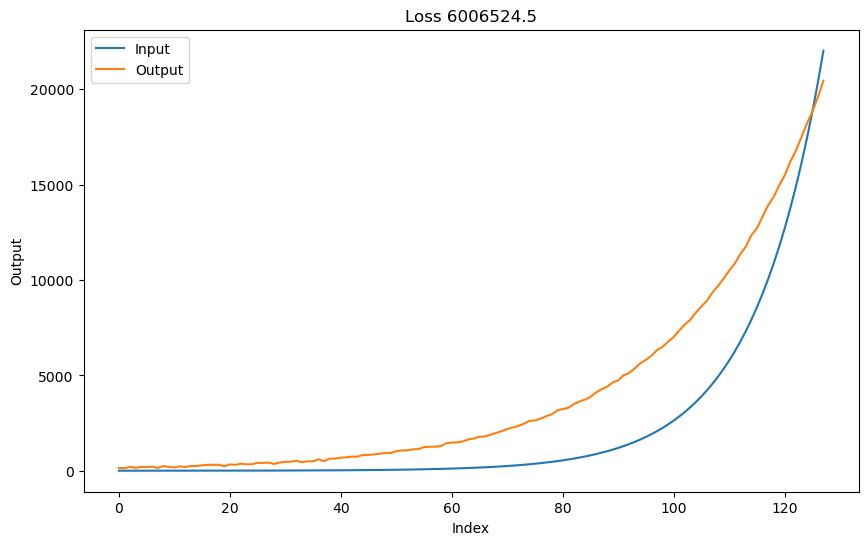

In [164]:
test = torch.linspace(0, 10, 128)
test = torch.exp(test)
compare_input_output(test, aem(test)[0].detach(), title=f"Loss {criterion(test, aem(test)[0].detach())}")

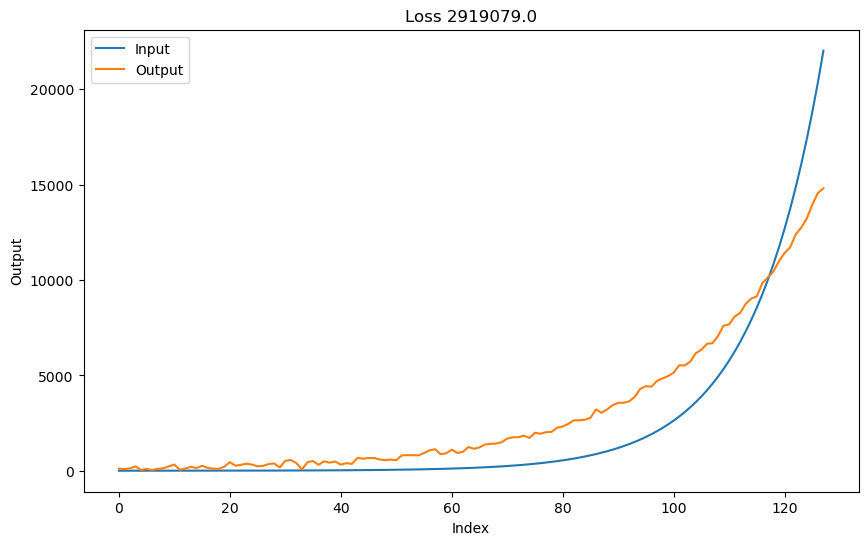

In [166]:
test = torch.linspace(0, 10, 128)
test = torch.exp(test)
compare_input_output(test, model(test)[0].detach(), title=f"Loss {criterion(test, model(test)[0].detach())}")